**Customer Segmentation using K-Means Clustering by Azimatul Matsniya** 
* **Sebagai tugas final project dari Virtual Internship Experience - Home Credit Indonesia**
* Tujuan dari analisis ini adalah mengelompokkan customer berdasarkan beberapa variabel yang mendukung seperti total income, umur, lama bekerja, dan lain-lain. 
* Dari customer segmetation ini dapat dijadikan untuk efektivitas campaign ke segmen pasar yang tepat.

In [1]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler)
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Portfolio/train.csv')

In [4]:
df.shape

(307511, 122)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
# memilih beberapa feature penting yang akan dianalisi dari keseluruhan featrue yang ada
data = df[['sk_id_curr','target','name_contract_type','code_gender','flag_own_car','flag_own_realty',
           'cnt_children','amt_income_total','amt_credit','amt_goods_price','name_income_type',
           'name_education_type','name_family_status','name_housing_type','region_population_relative','days_birth','days_employed',
           'occupation_type','cnt_fam_members','region_rating_client','weekday_appr_process_start',
           'hour_appr_process_start', 'organization_type']]
data.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_goods_price,...,name_housing_type,region_population_relative,days_birth,days_employed,occupation_type,cnt_fam_members,region_rating_client,weekday_appr_process_start,hour_appr_process_start,organization_type
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,351000.0,...,House / apartment,0.018801,-9461,-637,Laborers,1.0,2,WEDNESDAY,10,Business Entity Type 3
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,1129500.0,...,House / apartment,0.003541,-16765,-1188,Core staff,2.0,1,MONDAY,11,School
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,135000.0,...,House / apartment,0.010032,-19046,-225,Laborers,1.0,2,MONDAY,9,Government
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,297000.0,...,House / apartment,0.008019,-19005,-3039,Laborers,2.0,2,WEDNESDAY,17,Business Entity Type 3
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,513000.0,...,House / apartment,0.028663,-19932,-3038,Core staff,1.0,2,THURSDAY,11,Religion


In [7]:
# mengubah days_birth yang sebelumnya berupa satuan 'hari' diubah menjadi 'tahun' -> umur
data['days_birth'] = abs(round(data.iloc[:,15]/365))

<ipython-input-7-7335e036a484>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_birth'] = abs(round(data.iloc[:,15]/365))


In [8]:
# mengubah dari negatif menjadi positif
data['days_employed'] = abs(data.iloc[:,16])

<ipython-input-8-6e833d736768>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['days_employed'] = abs(data.iloc[:,16])


In [9]:
# melihat data yang mengandung missing value
data.isna().sum()

sk_id_curr                        0
target                            0
name_contract_type                0
code_gender                       0
flag_own_car                      0
flag_own_realty                   0
cnt_children                      0
amt_income_total                  0
amt_credit                        0
amt_goods_price                 278
name_income_type                  0
name_education_type               0
name_family_status                0
name_housing_type                 0
region_population_relative        0
days_birth                        0
days_employed                     0
occupation_type               96391
cnt_fam_members                   2
region_rating_client              0
weekday_appr_process_start        0
hour_appr_process_start           0
organization_type                 0
dtype: int64

In [10]:
# Data jenis pendapatan mengandung missing value, dapat diisi dengan 'none' 
data['occupation_type'] = data['occupation_type'].fillna('none')

<ipython-input-10-4159b5a18900>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['occupation_type'] = data['occupation_type'].fillna('none')


In [11]:
# Data pada kolom amt_goods_price mengandung missing value, namun tidak terlalu banyak. Akan dilakukan drop baris
data.drop(data[data.iloc[:,9].isna()].index, axis=0, inplace=True)
data.shape

<ipython-input-11-e23e1887d993>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data[data.iloc[:,9].isna()].index, axis=0, inplace=True)


(307233, 23)

In [12]:
# Untuk model kmeans, dipilih data-data yang hanya numerik 
train = data[['target','cnt_children','amt_income_total','amt_credit','amt_goods_price',
              'days_birth','days_employed', 'region_population_relative']]

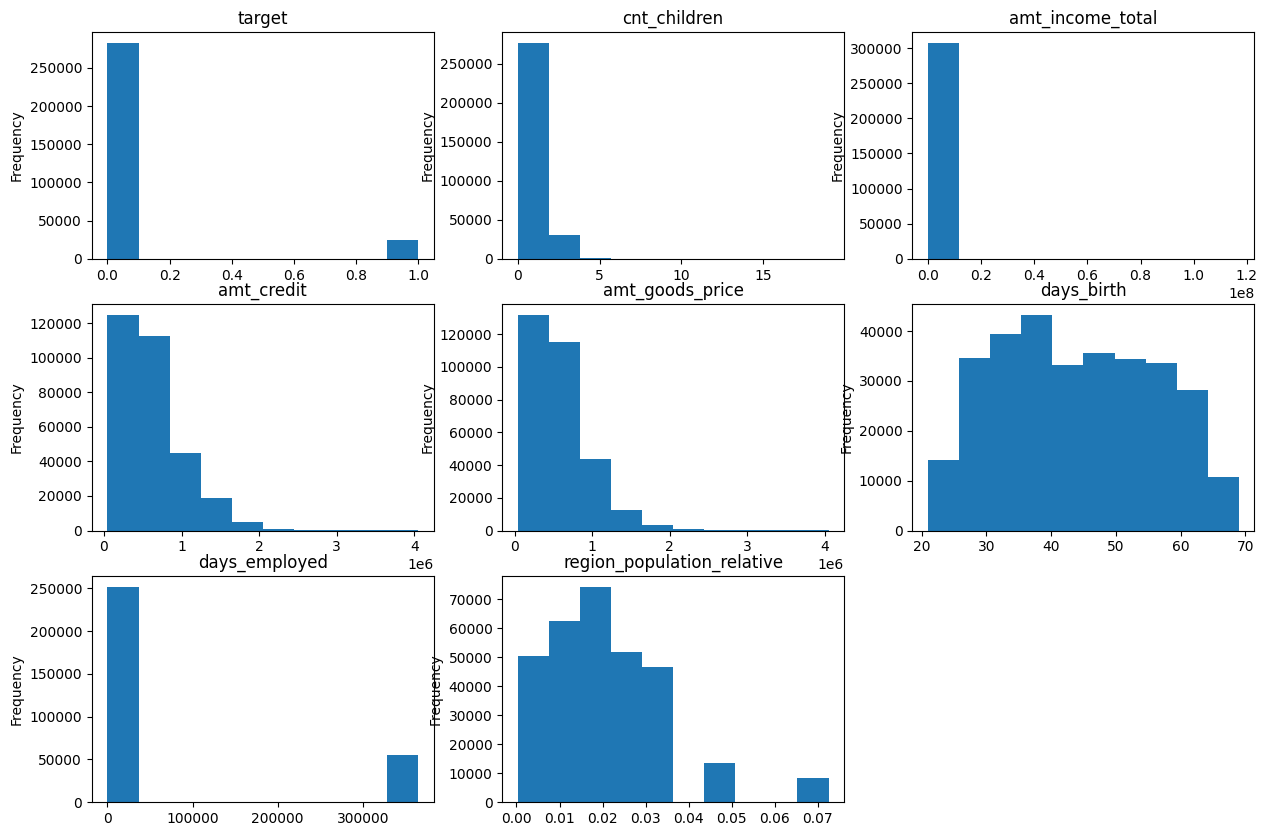

In [13]:
# Melihat distribusi dari masing-masing variabel
plt.figure(1, figsize=(15,10))
n=0
for column in train:
  n+=1
  plt.subplot(3,3,n)
  plt.title(column)
  train[column].plot(kind='hist')

In [14]:
# Log transformation digunakan untuk mengurangi skewness pada data
df3 = train.copy()
df3['amt_income_total'] = np.log(df3['amt_income_total'])
df3['amt_credit'] = np.log(df3['amt_credit'])
df3['amt_goods_price'] = np.log(df3['amt_goods_price'])
df3['days_birth'] = np.log(df3['days_birth'])
df3['region_population_relative'] = np.log(df3['region_population_relative'])

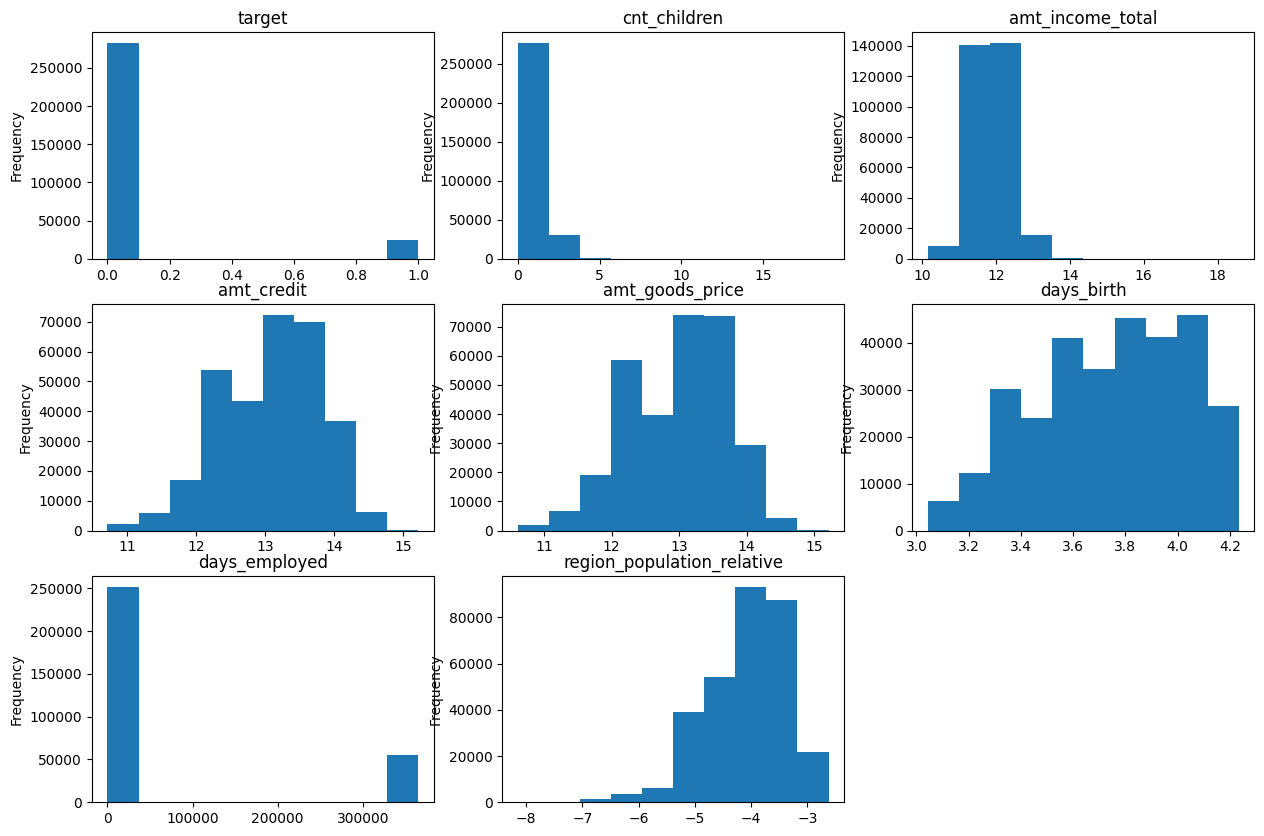

In [15]:
# Distribution setelah dilakukan log transformation
plt.figure(1, figsize=(15,10))
n=0
for column in df3:
  n+=1
  plt.subplot(3,3,n)
  plt.title(column)
  df3[column].plot(kind='hist')

In [16]:
# Melakukan standarisasi data dengan MinMax Scaler supaya rentang nya seragam
scaler = StandardScaler()

# Fit the scaler
scaler.fit(df3)

X_normal = scaler.transform(df3)
X_normal = pd.DataFrame(X_normal, index=df3.index, columns=df3.columns)
# summary statistic
X_normal.describe().round(2)

,target,cnt_children,amt_income_total,amt_credit,amt_goods_price,days_birth,days_employed,region_population_relative
count,307233.00,307233.00,307233.00,307233.00,307233.00,307233.00,307233.00,307233.00
mean,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.30,-0.58,-3.59,-3.30,-3.29,-2.46,-0.49,-5.65
25%,-0.30,-0.58,-0.57,-0.79,-0.81,-0.76,-0.48,-0.71
50%,-0.30,-0.58,-0.00,0.11,0.08,0.06,-0.47,0.17
75%,-0.30,0.81,0.63,0.74,0.65,0.86,-0.44,0.76
max,3.37,25.74,13.64,3.00,3.15,1.72,2.13,2.05


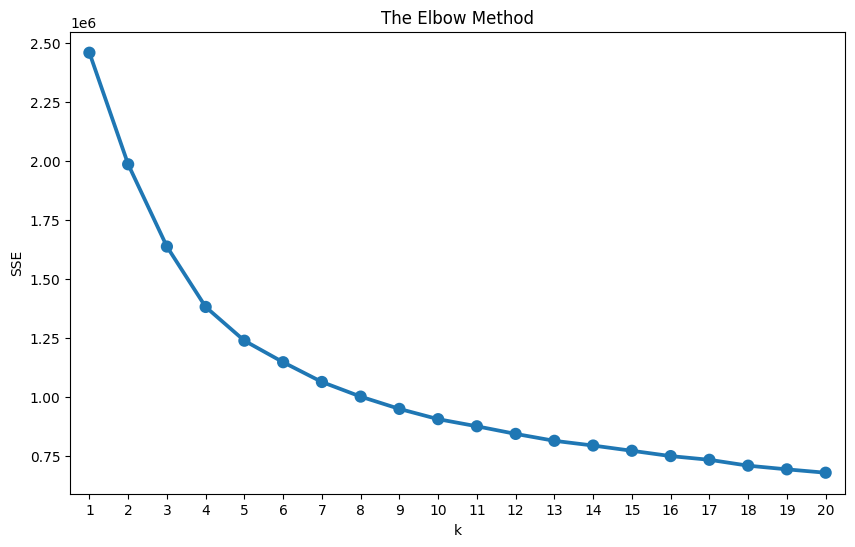

In [17]:
# Fit KMeans and menghitung SSE untuk setiap iterasi k
sse={}
for k in range(1, 21):
    kmeans = KMeans(n_clusters = k ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111)
    kmeans.fit(X_normal)
    sse[k] = kmeans.inertia_ 

# plot untuk elbow method    
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot nilai SSE for untuk setiap key 
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [18]:
kmeans = KMeans(n_clusters=3, random_state=1) 

# model fit k-means clustering menggunakan data normalisasi
kmeans.fit(X_normal)

# Extraksi label dari tiap cluster
cluster_labels = kmeans.labels_

# membuat kolom baru label di data train
train['label'] = cluster_labels
train.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-18-c454b2488680>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = cluster_labels


,target,cnt_children,amt_income_total,amt_credit,amt_goods_price,days_birth,days_employed,region_population_relative,label
0,1,0,202500.0,406597.5,351000.0,26.0,637,0.018801,2
1,0,0,270000.0,1293502.5,1129500.0,46.0,1188,0.003541,0
2,0,0,67500.0,135000.0,135000.0,52.0,225,0.010032,2
3,0,0,135000.0,312682.5,297000.0,52.0,3039,0.008019,2
4,0,0,121500.0,513000.0,513000.0,55.0,3038,0.028663,0


In [19]:
segm_analysis = train.groupby(['label']).mean()
segm_analysis

,target,cnt_children,amt_income_total,amt_credit,amt_goods_price,days_birth,days_employed,region_population_relative
label,,,,,,,,
0,0.068858,0.459485,210391.689255,870519.723598,783502.325168,42.417107,4493.445009,0.022474
1,0.053508,0.035287,133290.452789,529849.219728,476136.864208,59.969489,365236.455033,0.020596
2,0.109594,0.550586,132531.837623,282061.095577,251414.350380,37.996521,2659.368299,0.018926


Terbagi menjadi 3 golongan cluster, dengan rentang umur muda (rata-rata 38), midle (rata-rata 42). tua (rata-rata 60).

In [20]:
# membuat kolom baru label di tabel data
data['label'] = cluster_labels
data.columns

<ipython-input-20-c2ec93a3b128>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = cluster_labels


Index(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total',
       'amt_credit', 'amt_goods_price', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'region_population_relative', 'days_birth', 'days_employed',
       'occupation_type', 'cnt_fam_members', 'region_rating_client',
       'weekday_appr_process_start', 'hour_appr_process_start',
       'organization_type', 'label'],
      dtype='object')

In [21]:
# EDA untuk data setelah diberi label untuk customer sementation nya
data[['label','name_income_type','sk_id_curr']].groupby(['label','name_income_type'])['sk_id_curr'].count().reset_index()

,label,name_income_type,sk_id_curr
0,0,Businessman,9
1,0,Commercial associate,45462
2,0,Maternity leave,3
3,0,Pensioner,747
4,0,State servant,13182
5,0,Student,9
6,0,Unemployed,1
7,0,Working,83301
8,1,Pensioner,54419
9,1,Unemployed,20


In [22]:
data[['label','occupation_type','sk_id_curr']].groupby(['label','occupation_type'])['sk_id_curr'].count().reset_index()

,label,occupation_type,sk_id_curr
0,0,Accountants,6418
1,0,Cleaning staff,2116
2,0,Cooking staff,2817
3,0,Core staff,15378
4,0,Drivers,11218
5,0,HR staff,357
6,0,High skill tech staff,6847
7,0,IT staff,294
8,0,Laborers,28981
9,0,Low-skill Laborers,776


In [23]:
data[['label','flag_own_realty','sk_id_curr']].groupby(['label','flag_own_realty'])['sk_id_curr'].count().reset_index()

,label,flag_own_realty,sk_id_curr
0,0,N,46504
1,0,Y,96210
2,1,N,12917
3,1,Y,41523
4,2,N,34723
5,2,Y,75356
